Learn to predict the number of real solutions of the tritangent circles to three conics.

In [1]:
#TODO inspect predictions
#TODO check distribution of real counts in training data
#TODO ???

#TODO man bekommt nicht immer zwei weitere Lösungen!!
#TODO R18 -> R2 svd plot ral count

In [2]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras import regularizers
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [3]:
# Import Data
path = '/Users/las/Documents/GitHub/REU/hill_climb_w_solution_counts.xlsx'
df = pd.read_excel(path)

batch_1 = df[[col for col in df.columns if col[0].isupper()]].rename(str.lower, axis='columns')
# batch_2 = df[[col for col in df.columns if col[0].islower()]].rename(str.lower, axis='columns')
# batch_2.insert(0, "counts", np.array(batch_1['counts']) - 2)
# batch_2[batch_2['counts'] < 0] = 0
data = batch_1 # .append(batch_2).reset_index().drop('index', axis=1)

In [4]:
data.sample()

,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,counts
34995,0.302148,0.762812,0.652141,0.572907,0.189349,0.358988,0.20368,0.733967,0.792588,0.528097,0.312256,0.446718,0.457539,0.541798,0.408906,0.420021,-0.006907,0.155888,8


In [5]:
# Create Training and Validation Data
count = np.array(data['counts'].values.tolist(), dtype=np.int)
param = np.array(data.drop('counts', axis=1).values.tolist(), dtype=np.float64)
n = int(0.95*len(count))

count_train, count_val = count[:n], count[n:]
param_train, param_val = param[:n], param[n:]

/Users/las/opt/anaconda3/envs/REU/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [6]:
# Set Up Network Architecture
model = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=64, 
                       activation='relu', 
                       #kernel_regularizer=regularizers.l2(0.01), 
                       #bias_regularizer=regularizers.l2(0.01)
                       ),
    keras.layers.Dense(units=64, 
                       activation='relu', 
                       #kernel_regularizer=regularizers.l2(0.01), 
                       #bias_regularizer=regularizers.l2(0.01)
                       ),
    keras.layers.Dense(units=84, activation='softmax')
])

model.summary()

2022-08-08 16:57:48.985186: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 16:57:48.991269: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                608       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 84)                5460      
Total params: 12,340
Trainable params: 12,340
Non-trainable params: 0
_________________________________________________________________


In [7]:
sce = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='Adam', 
              loss=sce,
              metrics=['accuracy', sce])

In [13]:
# Train model
history = model.fit(param_train,
                    count_train,
                    verbose=2,
                    epochs=1000,
                    batch_size=64,
                    validation_data=(
                        param_val,
                        count_val
                    )
)

Train on 95000 samples, validate on 5000 samples
Epoch 1/1000
95000/95000 - 11s - loss: 1.7626 - accuracy: 0.3920 - sparse_categorical_crossentropy: 1.7625 - val_loss: 1.7564 - val_accuracy: 0.3920 - val_sparse_categorical_crossentropy: 1.7554
Epoch 2/1000
95000/95000 - 12s - loss: 1.7601 - accuracy: 0.3939 - sparse_categorical_crossentropy: 1.7601 - val_loss: 1.7492 - val_accuracy: 0.3950 - val_sparse_categorical_crossentropy: 1.7444
Epoch 3/1000
95000/95000 - 11s - loss: 1.7603 - accuracy: 0.3937 - sparse_categorical_crossentropy: 1.7602 - val_loss: 1.7578 - val_accuracy: 0.3922 - val_sparse_categorical_crossentropy: 1.7533
Epoch 4/1000
95000/95000 - 13s - loss: 1.7604 - accuracy: 0.3939 - sparse_categorical_crossentropy: 1.7604 - val_loss: 1.7580 - val_accuracy: 0.3884 - val_sparse_categorical_crossentropy: 1.7531
Epoch 5/1000
95000/95000 - 16s - loss: 1.7598 - accuracy: 0.3948 - sparse_categorical_crossentropy: 1.7598 - val_loss: 1.7576 - val_accuracy: 0.3908 - val_sparse_categoric

[]

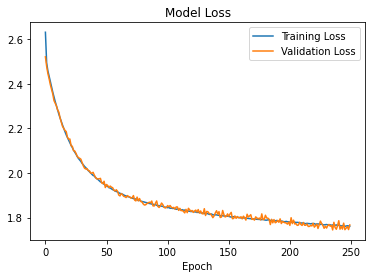

In [ ]:
# Graphs
fig = plt.figure()
plt.title('Model Loss')
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.plot()

In [ ]:
# Inspect Predictions 
fig = plt.figure()
prediction = 2*np.argmax(model.predict(data.drop('counts', axis=1)), axis=1)
# plt.plot(prediction, 'o')
# plt.show()

<Figure size 432x288 with 0 Axes>

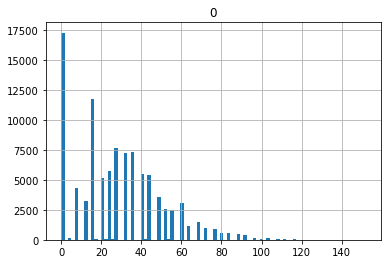

In [ ]:
# Distrbution of predictions
df = pd.DataFrame(prediction)
fig = df.hist(bins=92)

<AxesSubplot:>

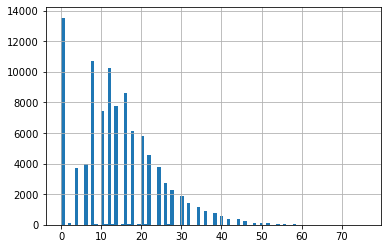

In [ ]:
# Distrbution of data
data.counts.hist(bins=92)